# Langmuir Probes for Dummies #
by Yonis le Grand



## Introduction ##

Langmuir Probes are used to determine the electron density and temeparature of a plasma. The following notebook analyses data from a single probe measurement. The first selects the segments that are of interest. The following section applies linear regression.

## Physics ##

When a plasma comes into contact with a wall, the much lighter electrons wich have a higher thermal velocity initially diffuse at a greater rate than the heavier ions. Because of this an ambi-polar field where the negatively charged wall repulses electrons and accelerates ions. This region where *maxwellian* electrons and electro-statically accelerated fluxes balance eachother out is called the sheath. The floating potential of the wall is determined completely by the electron temperature while the flux and therefore the current is determined by the electron density.

<table>
 <tr>
  <td>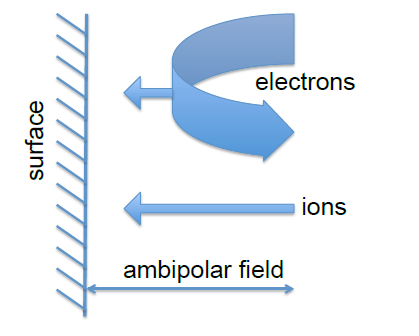</td>
  <td>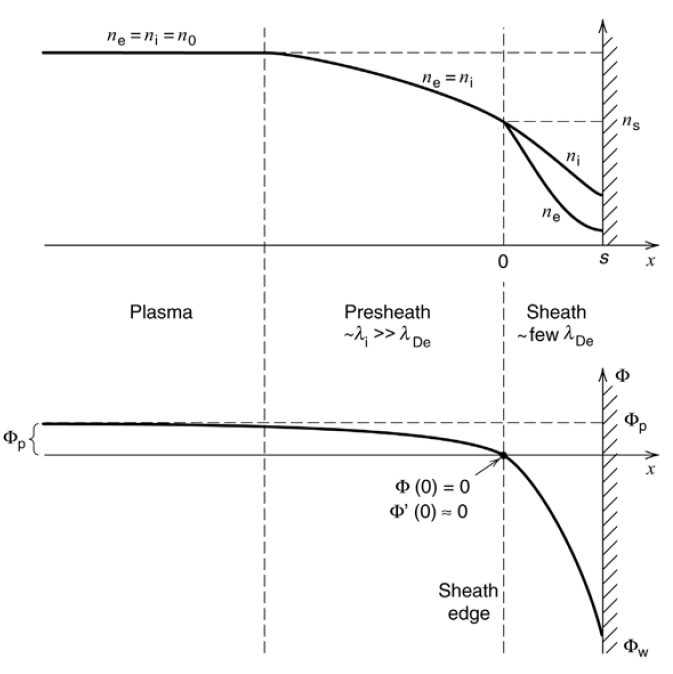</td>
 </tr>
 <tr>
  <td> If plasma is in contact with a material wall, an ambipolar electric field will arise that balances the outflow of electrons and ions by repelling most of the electrons. Only a fraction of the wall-directed electrons reach the wall, whereas all ions do.</td>
  <td>Qualitative behavior of sheath and presheath in contact with a wall. Density of the electrons and ions are represtend by $n_e$ and $n_i$ respectively. The potential drop within the plasma, $V_f$ (dippected here as $\Phi_p$) , constitutes the pre-sheath E-field that accelerates the ions to speed vse at the sheath edge (se). The aim is to determine the value of $\Phi_p$</td>
 </tr>
 <tr>
  <td>Source: van Rooij, G., Lopes Cardozo, N., de Blank, H. (2017). "Fusion reactors: extreme materials,intense plasma-wall interaction" course reader 3MF120. *TU Eindhoven.* </td>
  <td>Source: Liebermann, M.A., Lichtenberg, A.J. (2005)Principles of Plasma Discharges and material processing. *Wiley* </td>
 </tr>
</table>

A langmuir probe is used to measure this sheath introduced into the plasma and a sheath forms around it. The probe will obtain a floating potential $V_f$ negative to the plasma potential $V_p$. The density at the sheath edge ($n_s$ in the image on the right here above) is roughly half of the density of the upstream plasma density $n_0$. The voltage of the probe $V_s$ is than sweeped in relation to the ground potential. When the voltage is low enough, all the electrons are repelled from the wall and the ion flux is independant of the voltage applied. The measured current $I_{sat}$ is called the saturation current.
$$I_{sat}^+ = j_{sat}^+A_s = \frac{en_0c_sA_s}{2}$$     <center>(eq. 1)</center>

Where $j_{sat}$, $A_s$, $e$, $n$ and $c_s$ are the saturation current density, probe surface, electron charge, plasma upstream density and Bohm Sound speed respectively.

At higher probe voltages, the sheath potential drop is elliminated and electrons can flow freely to the wall. We can than use a maxwellian to calculate the current:
$$I = -I_{sat}^+\Big(1-e^{\frac{e}{kT_e}(V_s-V_f)}\Big)$$   <center>(eq. 2)</center>

Here k is the Boltzmann constant of $1.38 \cdot 10^{-23}$.

In [2]:
# Data Selection

# This first section extrats the Data from a csv file and selects the voltage and currents on a certain range.

# The following four lines import libraries that we will be using. 
import pandas as pd              # Pandas interperates the data and allows to maniulate a practical data frame.     
import numpy as np               # Numpy is usefull for scientific computing and linear algebra.
from numpy import exp, log     
import matplotlib.pyplot as plt  # pyplot plots the data

# It is most practical if the data file is formatted as a csv file with a single excell collumn where the 
# data is spererated by ','. If you have multiple collumns set the set the sep argument to ';'.
# If the decimal numbers in the data are represented with comma's instead of dot's: e.g. 0,5 instead of 0.5
# set the decimal argument to ",". An example is visible on the next line:
# df1 = pd.read_csv("C:/Langmuir_Probes/experimentaldata.csv", encoding ='latin1', sep =';',decimal="," )

plt.clf()  # Clear any existing plot data

# A normal csv file can be read with the following line
df1 = pd.read_csv("C:/Langmuir_Probes/eddot.csv", encoding ='latin1' ) # Fill in the file location here

#print list(df1.columns.values)                ## This line is to obtain the collumn names in the correct encoding. 
#print df1

# The collumn names from the original data were in portuguese.
# Here the collumns are renamed in english for practical reasons.
Tensao = u'Tens\xe3o [V]'
Corrente = u'Corrente [?A]'
df1.rename(columns={Tensao: 'Voltage', Corrente: 'Current'}, inplace=True)
#print df1

# Select the columns of interest.
df = df1[['Time','Voltage', 'Current']]

## Drop rows without measurements
# The following function drops rows with the same rounded value.
# We will only use it to allow a quick selection of the measurement data in this section.
df = df.drop_duplicates(subset='Voltage',keep='last') 
#print df

## Multiple measurements sweeps might have been made. 
#The folllowing step is to select a suitable section of the data.

# Find local peaks (max and min)
df['extrema'] = df.Voltage[((df.Voltage.shift(1) > df.Voltage) & (df.Voltage.shift(-1) > df.Voltage))
                        |((df.Voltage.shift(1) < df.Voltage) & (df.Voltage.shift(-1) < df.Voltage))]
df['extremabool']= df.extrema.notnull()

# Plot results
plt.scatter(df.index, df['extrema'], c='r')      # A scatter plot of the extrema on the measurement curves.
plt.xlabel('Measurement number')
plt.ylabel('Votlage, V [V]')
plt.title('Voltages measurements with extrema')
df.Voltage.plot()

#print df
plt.show()

# The following part selects the most suitable measurements for the I-V characteristic. 
# It does this by selecting the segment with the most datapoints
primary = None
secondary = None
prev = None
count=0
maxcount=0

for i,val in df.extremabool.iteritems():
    if val:
        if primary is not None:
            count=i-prev
            if count>maxcount:
                primary = prev
                secondary = i
                maxcount=count
                count=0
        else:
            primary = i 
        prev=i
    #elif (primary is not None):
        #count+=1
        
#print primary, secondary, secondary-primary

# Slice the data
df2 = df1.loc[primary:secondary,['Voltage','Current']]  


ImportError: No module named pandas

Below we can see the I-V characteristic of a sweep

In [3]:
plt.clf()
plt.plot(df2.Voltage, df2.Current,'o')
plt.ylabel('Current, I [A]')
plt.xlabel('Votlage, V [V]')
plt.title('I-V plot of a sweep')
plt.show()

NameError: name 'plt' is not defined

### Step 1: Exponetial Fit ###

We can see that the graph above is very similar to a typical Langmuir measurement seen below. The next step is to make an inital estimate with the assumption that the saturation current is constant. The fit equatio is eq.2:
$$I = -I_{sat}^+\Big(1-e^{\frac{e}{kT_e}(V_s-V_f)}\Big)$$ 
However here we use the electronvolt unit $\hat{T}_e$. Remeber:
$$\hat{T}_e = \frac{kT_e}{e}$$
So eq. 2 becomes:
$$I = -I_{sat}^+\Big(1-e^{\frac{(V_s-V_f)}{\hat{T}_e}}\Big)$$ 
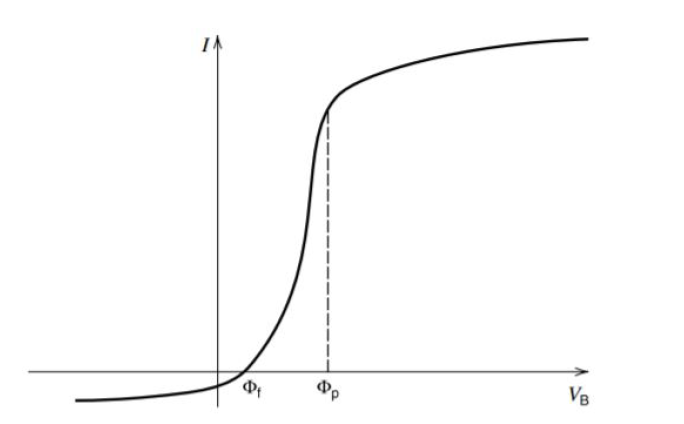

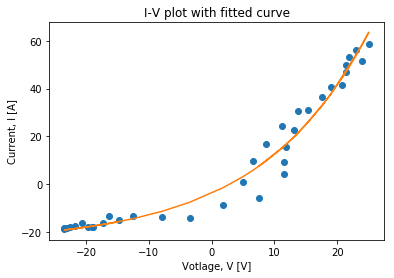

In [17]:
from scipy.optimize import curve_fit # Import curve fit function

# The following is equation 2
def init_exponential(Vs, Vf, Isat, Te):
        return -Isat*(1-np.exp((Vs-Vf)/Te))

# The next step is to preform a fit
def exponential_fit(func, volt, curr):    
    popt, pcov = curve_fit(func, volt, curr)  # Use non-linear least squares to fit a function, f, to data.
    V_float = popt[0]              # Vs, Vf are the probe and floating potential respectively  [V]
    I_sat   = popt[1]              # Saturation Current [A]
    Te      = popt[2]              # Te is the electron temperature [eV]
    #print V_float
    pp = init_exponential(df2.Voltage, *popt) # The fitted funtion
    return pp, V_float, I_sat, Te

pp, V_float, I_sat, Te = exponential_fit(init_exponential, df2.Voltage, df2.Current)

I_float = init_exponential(-V_float, V_float, I_sat, Te)    # Current at double floating Voltage
                                                            # To be used as an estimate of saturation Current
#print I_float

plt.plot(df2.Voltage, df2.Current,'o',df2.Voltage, pp)
plt.ylabel('Current, I [A]')
plt.xlabel('Votlage, V [V]')
plt.title('I-V plot with fitted curve')
plt.show()

### Step 2: Linear Regression ###
In reality the saturation current does not stay constant due to the thickening of the sheath at higher probe potential. For this reason we apply a linear fit to the negative values of our data to be used as a correction factor.
Perform a linear regression to the first few data points to determine the saturation current.

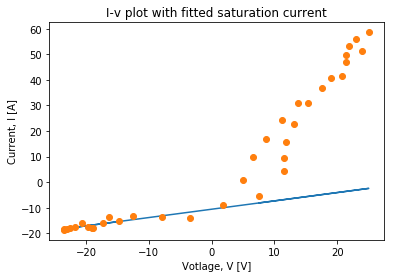

In [18]:
# The 'left' or saturated current is selected for a linear fit.
under0 = df2.Current[df2['Current']<=I_float] # Selecting the 'left' current
l = under0.index[-1]
f = np.polyfit(x = df2.Voltage.loc[:l], y = df2.Current.loc[:l], deg = 1) # linear least-squares fit to 'left side'

p = np.poly1d(f)       # Transform fit paramaters to function    
satval=p(df2.Voltage)  # Calculate linear 'saturation current' function on the whole data range
plt.plot(df2.Voltage,satval)
plt.plot(df2.Voltage, df2.Current,'o')
plt.ylabel('Current, I [A]')
plt.xlabel('Votlage, V [V]')
plt.title('I-v plot with fitted saturation current')
plt.show()




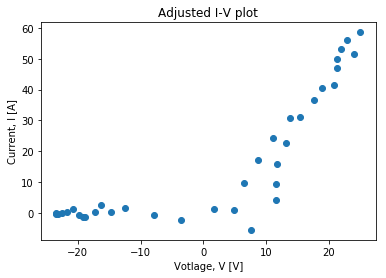

In [19]:
##Adjusting the data
# Here the estimate is cleaned. The saturation current is than subtratected from the left values 
# to balance the sheath thickening effect.

ii=0
for i, measurement in df2.Current.iteritems():
    if measurement<=I_float:         
        df2.loc[i,'Current']-= satval[ii]
        ii+=1

    
#print df2.Current
plt.plot(df2.Voltage, df2.Current,'o')
plt.ylabel('Current, I [A]')
plt.xlabel('Votlage, V [V]')
plt.title('Adjusted I-V plot')
plt.show()

## step 3: Final Estimate ##

Now that we have corrected the saturation value to fit the theoretical model we can preform step 1 again to give us the actual vaules of $\hat{T}_e$, $I_{sat}$ and $V_f$ 

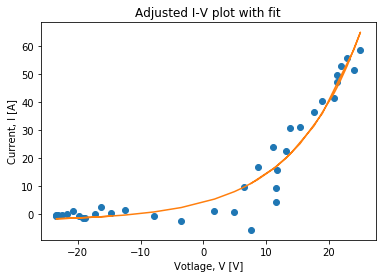

The floating potential is: -11.2484597894 V 
Saturation Current is: 2.31430377358 A 
Electron Temperature is 10.7588263385 eV


In [20]:
# Final estimation

pp, V_float, I_sat, Te = exponential_fit(init_exponential, df2.Voltage, df2.Current)

plt.plot(df2.Voltage, df2.Current,'o',df2.Voltage, pp)
plt.ylabel('Current, I [A]')
plt.xlabel('Votlage, V [V]')
plt.title('Adjusted I-V plot with fit')
plt.show()
print "The floating potential is: {} V \nSaturation Current is: {} A \nElectron Temperature is {} eV".format(V_float, I_sat, Te)

## Step 4: Density ##
Now we only need the density. Remember that the ion current is dependant on the density at the sheath entrance while the sheath potential drop is dependant on the electron temperature. This is because the high-speed electrons create the ambipolar field. The electron density drops exponentiall according to the boltzmann relation as only "hotter" or faster electrons can approac the sheath:
$$ n_e(x) = n_{se} exp \Big(\frac{\Phi(x)}{\hat{T}_e}\Big) $$
Where $x$ is the distance towards the wall from the sheath edge and $n_{se}$ is the density at sheat edge.
The ions are accelarated electrostatically. An easy way to calculate the minimum ion spead would be equating the cange in ion kinetic energy to the potential drop:
$$\frac{1}{2}m_i u(x)^2 = \frac{1}{2}m_i u_0^2 -e \Phi(x)$$ 
Here $m_i$ is the ion mass. Combining with the poisson equation we can arrive at the sound speed. This is called the Bohm Criterion. The derivation can be found at https://en.wikipedia.org/wiki/Debye_sheath#Mathematical_treatment.

### The Bohm Criterion: ###
We finally arrive at the conclusion that the ion speed is greater or equal than the sound speed:
$$ u_{se} \geq c_s = \sqrt{\frac{e \hat{T}_e}{m_i}}$$
<center>(eq. 3)</center>

We can no implement this $c_s$ into eq. 1:
$$I_{sat}^+ = j_{sat}^+A_s = \frac{en_0c_sA_s}{2}$$ 
Remeber that $A_s$ is the probe surface area.




In [21]:
## Calculate the density.
# First fill in the dimensions of the probe:
l_e = 0.01                   # Probe length in meters. Verify if this is correct!
d_e = 2*10**(-4)             # Probe diameter in meters. Verify if this is correct!

A_s = l_e*d_e*np.pi            #  Probe surface are in m^2.

# Physical parameters:
e   = 1.6*10**(-19)          # Electron charge in Coulombs.
m_i = 1.67*10**(-27)         # Ion mass in kg for Hydrogen.

# Results:
c_s = (e*Te/m_i)**0.5        # Bohm soundspeed

n_0 = I_sat*2/(e*c_s*A_s)    # Upstream plasma density

print "The electron density is: {} m^-3 \nElectron Temperature is {} eV".format(n_0, Te)

The electron density is: 1.43405663644e+20 m^-3 
Electron Temperature is 10.7588263385 eV
